<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/DenisRang/a1-simulated-annealing-and-sampling/blob/master/a1_task2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [1]:
!wget https://raw.githubusercontent.com/hflabs/city/master/city.csv

--2020-01-30 12:35:52--  https://raw.githubusercontent.com/hflabs/city/master/city.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324436 (317K) [text/plain]
Saving to: ‘city.csv’

city.csv            100%[===================>] 316.83K  --.-KB/s    in 0.04s   

2020-01-30 12:35:52 (8.29 MB/s) - ‘city.csv’ saved [324436/324436]



In [115]:
!apt-get install libgeos-dev
!pip install --user https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (103 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     | 206.3MB 359kB/s
     |█████████████████

In [6]:
!pip install geopy

In [0]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt

### Observe data

In [2]:
import pandas as pd

cities_df = pd.read_csv('/content/city.csv')
print(cities_df.columns)
cities_df = cities_df.ix[:30,['city','geo_lat','geo_lon']]
print(cities_df.head())
print(cities_df.describe())

Index(['address', 'postal_code', 'country', 'federal_district', 'region_type',
       'region', 'area_type', 'area', 'city_type', 'city', 'settlement_type',
       'settlement', 'kladr_id', 'fias_id', 'fias_level', 'capital_marker',
       'okato', 'oktmo', 'tax_office', 'timezone', 'geo_lat', 'geo_lon',
       'population', 'foundation_year'],
      dtype='object')
            city    geo_lat    geo_lon
0       Адыгейск  44.878414  39.190289
1         Майкоп  44.609827  40.100661
2  Горно-Алтайск  51.958103  85.960324
3         Алейск  52.492251  82.779361
4        Барнаул  53.347997  83.779806
         geo_lat     geo_lon
count  31.000000   31.000000
mean   53.771578   86.729900
std     4.984517   33.034242
min    44.609827   38.963697
25%    51.259760   62.836640
50%    52.539386   83.779806
75%    53.889253  126.006339
max    65.839808  129.439181


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


In [3]:
from geopy.distance import geodesic
from tqdm import tqdm


def dist(origin, dist):
    return geodesic(origin, dist).kilometers

def create_dist_matrix(cities):
    num_cities=len(cities)
    dest_matrix = np.zeros(shape=(num_cities,num_cities))
    pbar = tqdm(total=num_cities)
    for i in range(num_cities):
        pbar.update(1)
        for j in range(num_cities):
            dest_matrix[i,j]=dist(cities.iloc[i,1:],cities.iloc[j,1:])
    pbar.close()
    return dest_matrix

dist_matrix = create_dist_matrix(cities_df)
np.savez_compressed('dist_matrix.npz',dist_matrix)

100%|██████████| 31/31 [00:01<00:00, 27.48it/s]


In [0]:
def annealing(random_start,
            cost_function,
            random_neighbour,
            temperature,
            debug=True):
  """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
  state = random_start(dist_matrix)
  cost = cost_function(state)
  initial_weight = cost
  step = 1
  T = 10000
  costs, states, temperatures = [cost], [state], [T]
  temperature_cooled_down = 0.01
  while T > temperature_cooled_down:
    new_state = random_neighbour(state)
    new_cost = cost_function(new_state)
    alpha = get_alpha(cost, new_cost, T)
    u = rn.random()
    if debug: print(f"Step #{step}:  T = {T:.2f}, cost = {cost:.2f}, new_cost = {new_cost:.2f}, alpha = {alpha:.2f}, u = {u:.2f}")
    if alpha >= u:
      state, cost = new_state, new_cost
      states.append(state)
      costs.append(cost)
      temperatures.append(T)
    step += 1
    T = temperature(T)
  print('Initial weight: ', initial_weight)
  print('Final weight: ', cost)
  print('Improvement: ', round((initial_weight - cost) / (initial_weight), 4) * 100, '%')
  return step, initial_weight, cost, state, states, costs, temperatures

def path_dist(coords):
  distance=0
  for i in range(1,len(dist_matrix)):
    distance += dist_matrix[coords[i-1], coords[i]]
  return distance

def cost_function(coords):
    """Calcuate weight"""
    return path_dist(coords)

def random_neighbour(coords):
  """Generate new weights using the normal distribution with mean equal to previous weights"""
  candidate = list(coords)
  l = rn.randint(2, len(dist_matrix) - 1)
  i = rn.randint(0, len(dist_matrix) - l)

  candidate[i: (i + l)] = reversed(candidate[i: (i + l)])
  # print(coords)
  # print(candidate)
  return candidate

def get_alpha(cost, new_cost, temperature):
  """Calculate acceptance ratio"""
  # print(f'{(new_cost - cost)}, {- (new_cost - cost) / temperature},{np.exp(- (new_cost - cost) / temperature)}')
  return np.exp(- (new_cost - cost) / temperature)

def temperature(old_temperature):
  """ Temperature dicreasing as the process goes on."""
  a = 0.99
  return old_temperature*a

def nearest_neighbour_solution(dist_matrix):
    '''
    Computes the initial solution (nearest neighbour strategy)
    '''
    node = rn.randrange(len(dist_matrix))
    result = [node]

    nodes_to_visit = list(range(len(dist_matrix)))
    nodes_to_visit.remove(node)

    while nodes_to_visit:
        nearest_node = min([(dist_matrix[node][j], j) for j in nodes_to_visit], key=lambda x: x[0])
        node = nearest_node[1]
        nodes_to_visit.remove(node)
        result.append(node)

    return result

In [71]:
data = np.load('dist_matrix.npz')
dist_matrix = data['arr_0']

dist_matrix = dist_matrix
num_steps, initial_weight, final_weight, final_coord, states, costs, temperatures = annealing(nearest_neighbour_solution,
                                                          cost_function,
                                                          random_neighbour,
                                                          temperature,
                                                          debug=True)

Step #1:  T = 10000.00, cost = 10892.84, new_cost = 20237.15, alpha = 0.39, u = 0.40
Step #2:  T = 9900.00, cost = 10892.84, new_cost = 17034.35, alpha = 0.54, u = 0.81
Step #3:  T = 9801.00, cost = 10892.84, new_cost = 13519.71, alpha = 0.76, u = 0.63
Step #4:  T = 9702.99, cost = 13519.71, new_cost = 19820.47, alpha = 0.52, u = 0.36
Step #5:  T = 9605.96, cost = 19820.47, new_cost = 20097.76, alpha = 0.97, u = 0.92
Step #6:  T = 9509.90, cost = 20097.76, new_cost = 19996.99, alpha = 1.01, u = 0.08
Step #7:  T = 9414.80, cost = 19996.99, new_cost = 22408.29, alpha = 0.77, u = 0.26
Step #8:  T = 9320.65, cost = 22408.29, new_cost = 22561.98, alpha = 0.98, u = 0.80
Step #9:  T = 9227.45, cost = 22561.98, new_cost = 32069.02, alpha = 0.36, u = 0.17
Step #10:  T = 9135.17, cost = 32069.02, new_cost = 33803.60, alpha = 0.83, u = 0.44
Step #11:  T = 9043.82, cost = 33803.60, new_cost = 34049.71, alpha = 0.97, u = 0.07
Step #12:  T = 8953.38, cost = 34049.71, new_cost = 34060.35, alpha = 1.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


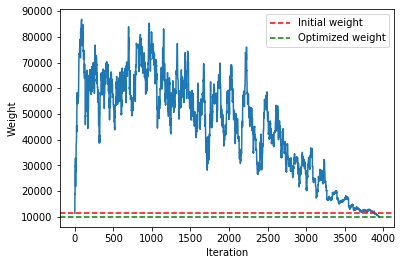

In [7]:
def plot():
    plt.plot([i for i in range(len(costs))], costs)
    line_init = plt.axhline(y=initial_weight, color='r', linestyle='--')
    line_min = plt.axhline(y=final_weight, color='g', linestyle='--')
    plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
    plt.ylabel('Weight')
    plt.xlabel('Iteration')
    plt.show()

plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

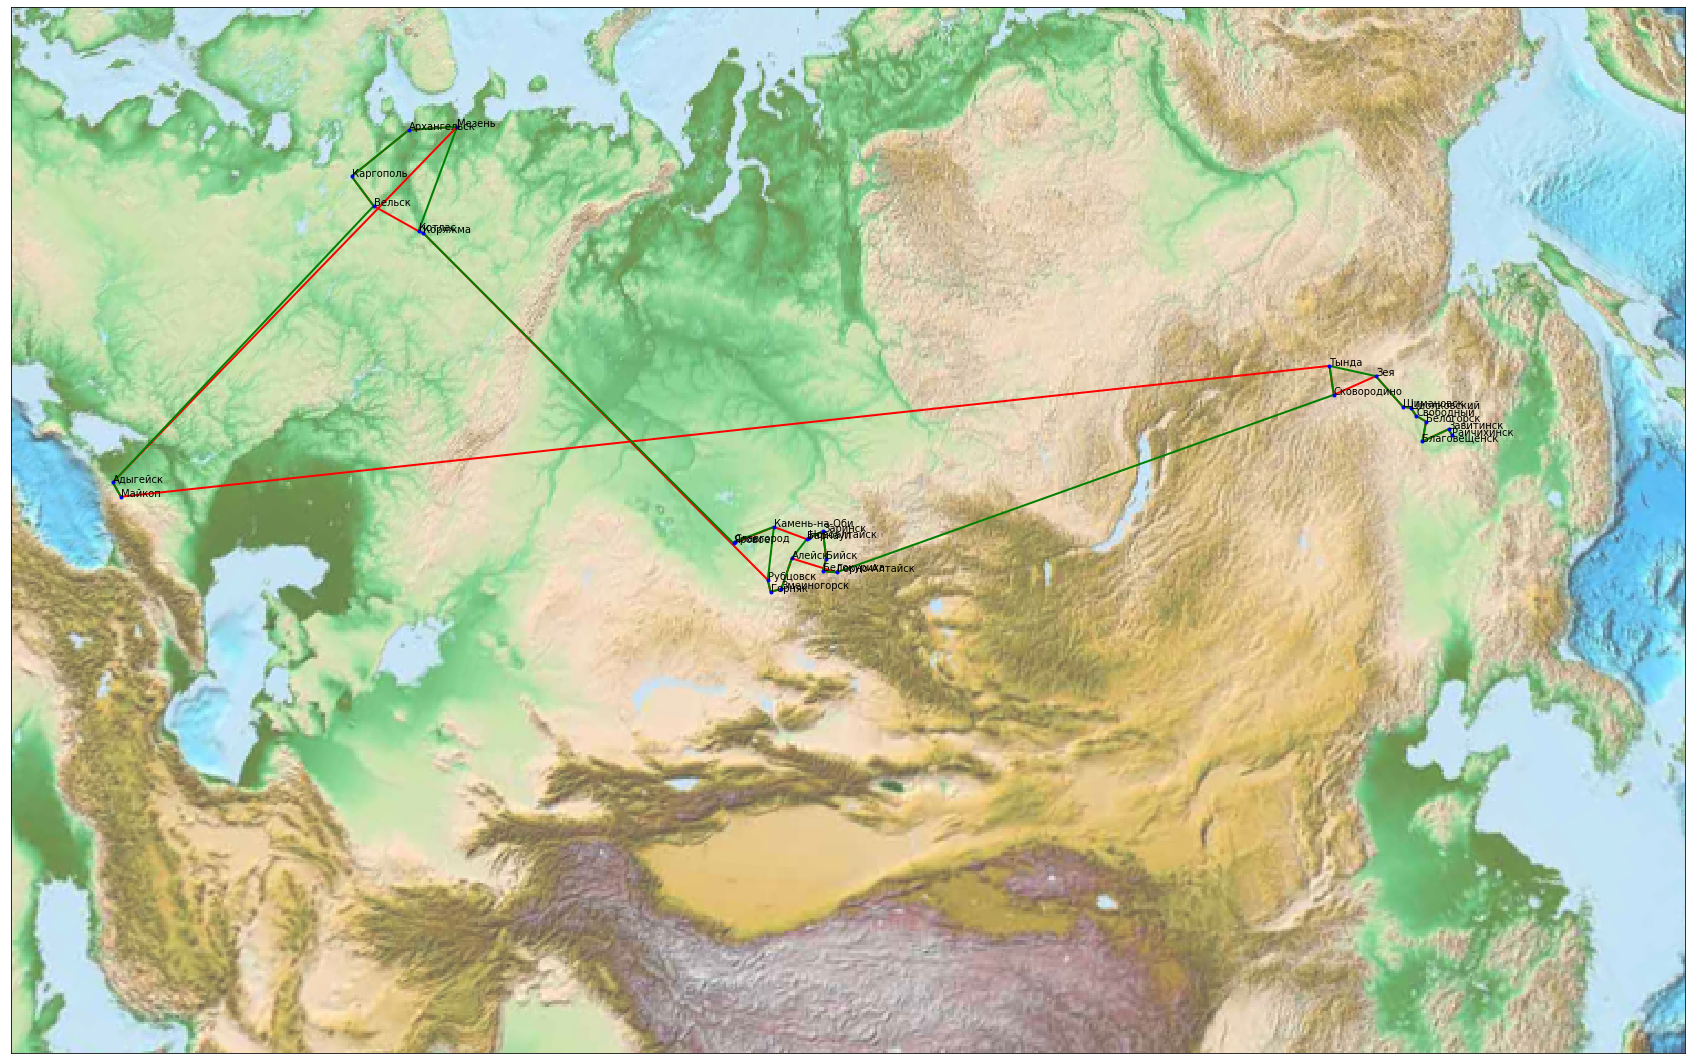

In [67]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection

min_lat = np.mean(cities_df['geo_lat'])
min_lon = np.mean(cities_df['geo_lon'])

fig = plt.figure(figsize=(30, 20))
# boundary resolution must be one of 'c','l','i','h' or 'f'
m = Basemap(projection='lcc', resolution='i',
            width=8E6, height=5E6,lat_0=min_lat, lon_0=min_lon,) 
m.etopo(scale=0.7, alpha=0.7)
# Map (long, lat) to (x, y) for plotting
x,y =[],[]
for i in range(len(final_coord)):
  coord_idx = final_coord[i]
  single_x, single_y = m(cities_df.ix[coord_idx,'geo_lon'],cities_df.ix[coord_idx,'geo_lat'])
  x.append(single_x)
  y.append(single_y)
  plt.plot(single_x, single_y, 'ok', markersize=3, color='blue') 
  plt.text(single_x, single_y, cities_df.ix[coord_idx,'city'], fontsize=10)

coords=[]
for i in range(1,len(states[0])):
  coord1_idx = states[0][i-1]
  coord2_idx = states[0][i]
  coord1 = m(cities_df.ix[coord1_idx,'geo_lon'],cities_df.ix[coord1_idx,'geo_lat'])
  coord2 = m(cities_df.ix[coord2_idx,'geo_lon'],cities_df.ix[coord2_idx,'geo_lat'])
  coords.append([coord1,coord2])

lc = LineCollection(coords, color=["red"], lw=2)
plt.gca().add_collection(lc)

coords=[]
for i in range(1,len(final_coord)):
  coord1_idx = final_coord[i-1]
  coord2_idx = final_coord[i]
  coord1 = m(cities_df.ix[coord1_idx,'geo_lon'],cities_df.ix[coord1_idx,'geo_lat'])
  coord2 = m(cities_df.ix[coord2_idx,'geo_lon'],cities_df.ix[coord2_idx,'geo_lat'])
  coords.append([coord1,coord2])

lc = LineCollection(coords, color=["green"], lw=2)
plt.gca().add_collection(lc)


plt.show()